# Proyek Klasifikasi Gambar: Rice Grains Classification
- **Nama:** Taufan Fajarama P. Ruslanali
- **Email:** tfpruslanali@gmail.com
- **ID Dicoding:** tfajarama

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip uninstall tensorflow
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.18.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.18.0
  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
  Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
Using cached keras-2.15.0

In [2]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.15.0


## Data Preparation

### Data Loading

Masukkan file json yang berisi username Kaggle dan API key token profile Anda.

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

In [6]:
!rm -rf rice_images/

Dataset diambil dari Kaggle (https://www.kaggle.com/datasets/mbsoroush/rice-images-dataset)

In [7]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mbsoroush/rice-images-dataset
!mkdir -p /content/rice_images
!unzip rice-images-dataset.zip -d /content/rice_images

Streaming output truncated to the last 5000 lines.
  inflating: /content/rice_images/Karacadag/Karacadag (550).jpg  
  inflating: /content/rice_images/Karacadag/Karacadag (5500).jpg  
  inflating: /content/rice_images/Karacadag/Karacadag (5501).jpg  
  inflating: /content/rice_images/Karacadag/Karacadag (5502).jpg  
  inflating: /content/rice_images/Karacadag/Karacadag (5503).jpg  
  inflating: /content/rice_images/Karacadag/Karacadag (5504).jpg  
  inflating: /content/rice_images/Karacadag/Karacadag (5505).jpg  
  inflating: /content/rice_images/Karacadag/Karacadag (5506).jpg  
  inflating: /content/rice_images/Karacadag/Karacadag (5507).jpg  
  inflating: /content/rice_images/Karacadag/Karacadag (5508).jpg  
  inflating: /content/rice_images/Karacadag/Karacadag (5509).jpg  
  inflating: /content/rice_images/Karacadag/Karacadag (551).jpg  
  inflating: /content/rice_images/Karacadag/Karacadag (5510).jpg  
  inflating: /content/rice_images/Karacadag/Karacadag (5511).jpg  
  inflating: 

Folder dataset tidak hanya berisi folder tiap kelas dan terdapat file yang bukan merupakan dataset, maka file tersebut perlu dihapus.

In [8]:
dataset_dir = 'rice_images/'

# Check if the directory exists
if os.path.exists(dataset_dir):
    # List all files and directories in the dataset directory
    all_items = os.listdir(dataset_dir)

    # Iterate over all items and delete files
    for item in all_items:
        item_path = os.path.join(dataset_dir, item)
        if os.path.isfile(item_path):
            os.remove(item_path)
            print(f"Deleted file: {item_path}")

    # Print remaining items in the dataset directory
    remaining_items = os.listdir(dataset_dir)
    print(f"Remaining items in the dataset directory: {remaining_items}")
else:
    print(f"The directory {dataset_dir} does not exist.")

Deleted file: rice_images/S0168169921003021.pdf
Deleted file: rice_images/Rice_Citation_Request.txt
Remaining items in the dataset directory: ['Basmati', 'Ipsala', 'Jasmine', 'Karacadag', 'Arborio']


Memeriksa resolusi gambar dari setiap data di dalam dataset.

In [9]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution(dataset_dir)

Basmati: 15000
- (250, 250)
---------------
Ipsala: 15000
- (250, 250)
---------------
Jasmine: 15000
- (250, 250)
---------------
Karacadag: 15000
- (250, 250)
---------------
Arborio: 15000
- (250, 250)
---------------

Total: 75000


#### Plot Sampel Gambar

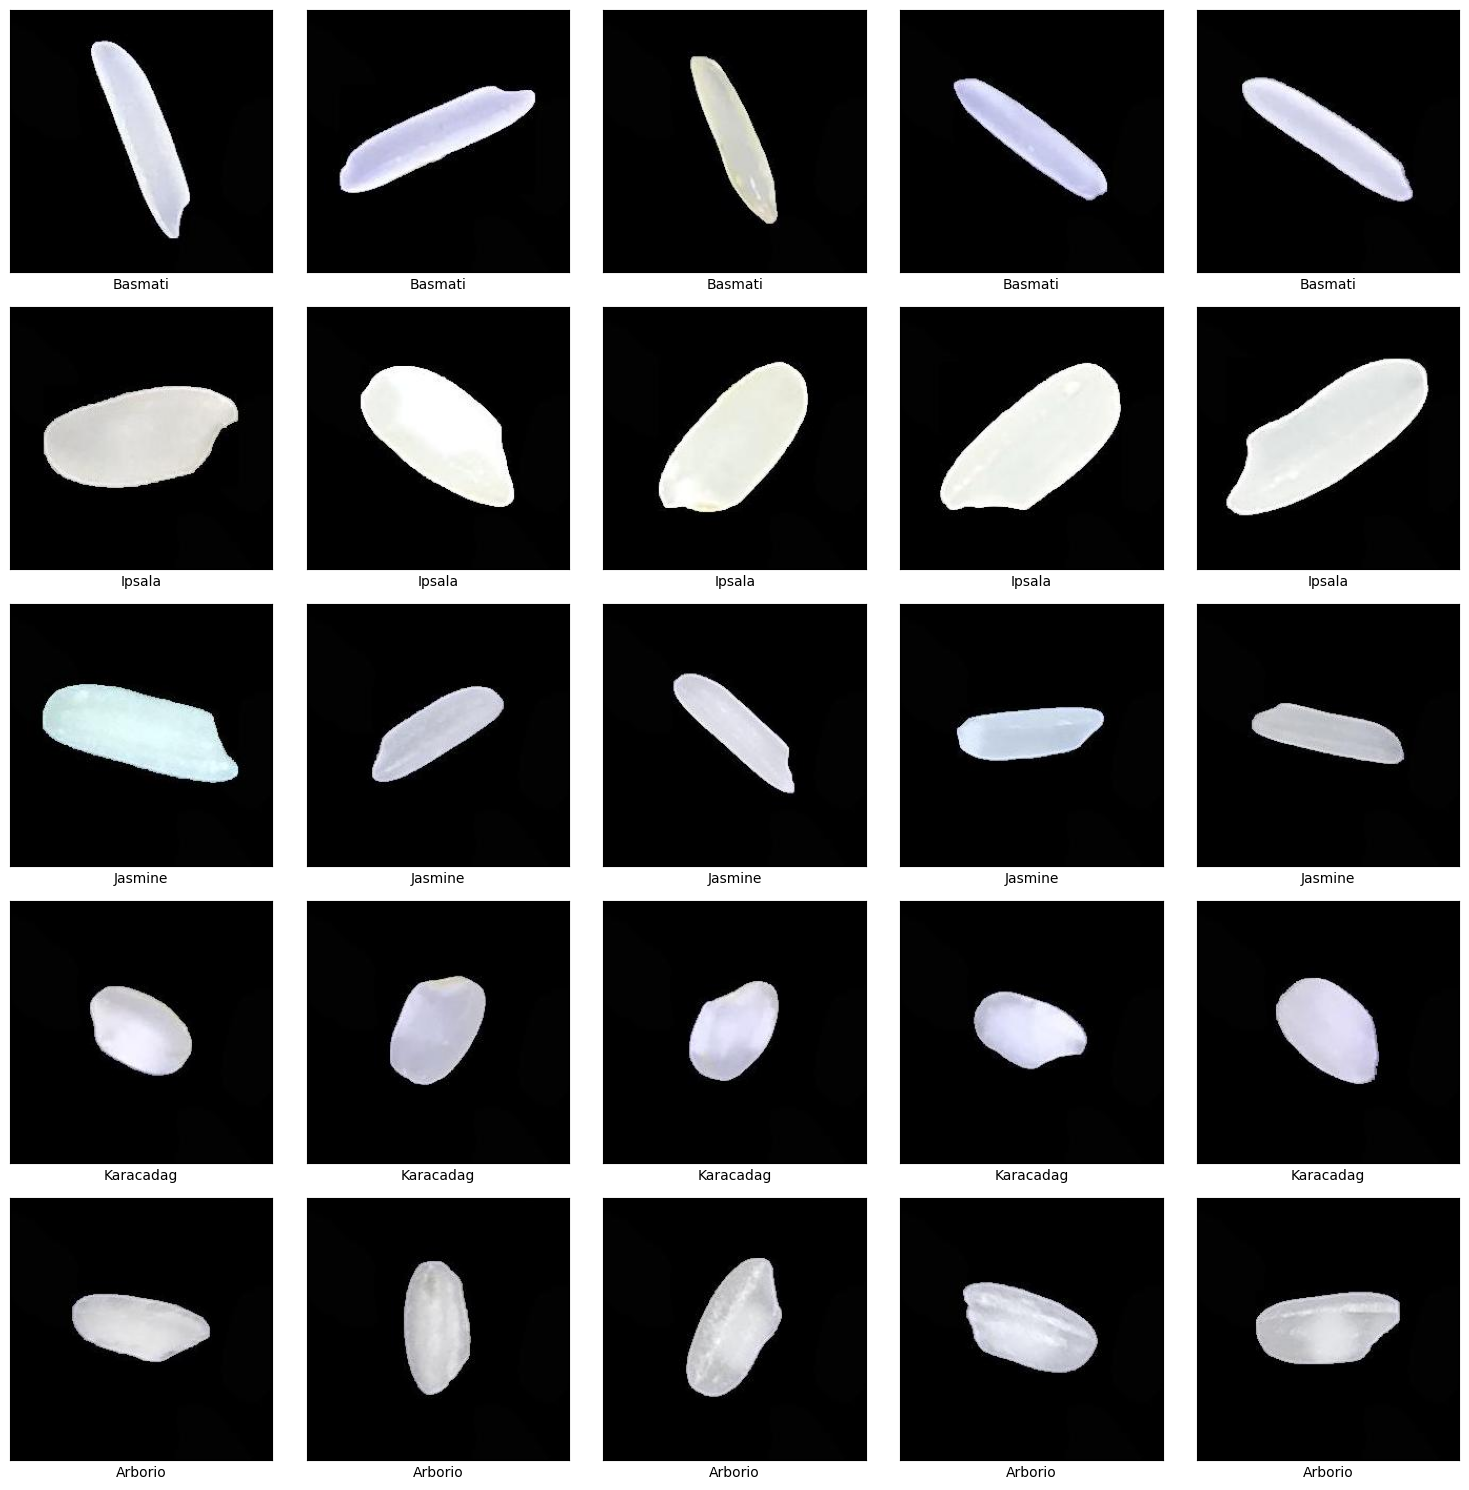

In [10]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
eye_image = {}

# Tentukan path sumber
path = "rice_images/"
for i in os.listdir(path):
    eye_image[i] = os.listdir(os.path.join(path, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(eye_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(eye_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

#### Plot Distribusi Kelas

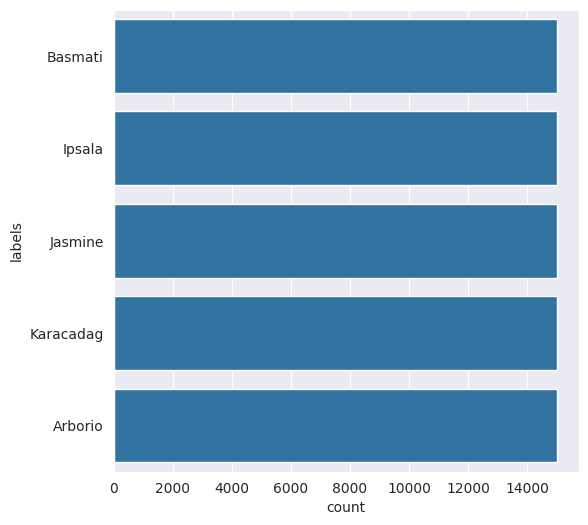

In [11]:
# Define source path
path = "rice_images"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [12]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'rice_images/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Arborio,15000
Basmati,15000
Ipsala,15000
Jasmine,15000
Karacadag,15000


In [13]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y)

In [14]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 60000
test size 15000


In [15]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels   
test   Arborio       3000
       Basmati       3000
       Ipsala        3000
       Jasmine       3000
       Karacadag     3000
train  Arborio      12000
       Basmati      12000
       Ipsala       12000
       Jasmine      12000
       Karacadag    12000
dtype: int64 


                                          path   labels    set
19461   rice_images/Arborio/Arborio (2711).jpg  Arborio  train
50275   rice_images/Arborio/Arborio (3767).jpg  Arborio  train
39366  rice_images/Jasmine/Jasmine (12388).jpg  Jasmine  train
20368   rice_images/Arborio/Arborio (2551).jpg  Arborio  train
4076    rice_images/Jasmine/Jasmine (2732).jpg  Jasmine  train


In [16]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "rice_images/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [17]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_arborio = os.path.join(TRAIN_DIR + '/Arborio')
train_basmati = os.path.join(TRAIN_DIR + '/Basmati')
train_ipsala = os.path.join(TRAIN_DIR + '/Ipsala')
train_jasmine = os.path.join(TRAIN_DIR + '/Jasmine')
train_karacadag = os.path.join(TRAIN_DIR + '/Karacadag')

test_arborio = os.path.join(TEST_DIR + '/Arborio')
test_basmati = os.path.join(TEST_DIR + '/Basmati')
test_ipsala = os.path.join(TEST_DIR + '/Ipsala')
test_jasmine = os.path.join(TEST_DIR + '/Jasmine')
test_karacadag = os.path.join(TEST_DIR + '/Karacadag')

print("Total number of arborio images in training set: ",len(os.listdir(train_arborio)))
print("Total number of basmati images in training set: ",len(os.listdir(train_basmati)))
print("Total number of ipsala images in training set: ",len(os.listdir(train_ipsala)))
print("Total number of jasmine images in training set: ",len(os.listdir(train_jasmine)))
print("Total number of karacadag images in training set: ",len(os.listdir(train_karacadag)))

print("\nTotal number of arborio images in test set: ",len(os.listdir(test_arborio)))
print("Total number of basmati images in test set: ",len(os.listdir(test_basmati)))
print("Total number of ipsala images in test set: ",len(os.listdir(test_ipsala)))
print("Total number of jasmine images in test set: ",len(os.listdir(test_jasmine)))
print("Total number of karacadag images in test set: ",len(os.listdir(test_karacadag)))

Total number of arborio images in training set:  12000
Total number of basmati images in training set:  12000
Total number of ipsala images in training set:  12000
Total number of jasmine images in training set:  12000
Total number of karacadag images in training set:  12000

Total number of arborio images in test set:  3000
Total number of basmati images in test set:  3000
Total number of ipsala images in test set:  3000
Total number of jasmine images in test set:  3000
Total number of karacadag images in test set:  3000


#### Image Data Generator

In [18]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="grayscale",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 48000 images belonging to 5 classes.
Found 12000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


## Modelling

In [19]:
# from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions

# Modify the input layer to accept grayscale images
input_layer = Input(shape=(150, 150, 1))
# x = Conv2D(3, (3, 3), padding='same')(input_layer)  # Convert grayscale to 3 channels

# # Load the EfficientNetB0 model without the top layers
# pretrained_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=x)

# # Make all the layers in the pre-trained model non-trainable
# for layer in pretrained_model.layers:
#   layer.trainable = False

# x = pretrained_model(x)

# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
x = Conv2D(32, (4, 4),padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
x = Conv2D(32, (7, 7), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Flatten layer
x = Flatten()(x)
# 1nd Dense Layer
x = Dense(128, activation = 'relu')(x)
# 1nd Dropout Layer
x = Dropout(0.5)(x)
# 2nd Dense Layer
x = Dense(64, activation = 'relu')(x)
# 2nd Dropout Layer
x = Dropout(0.3)(x)
# Final Dense layer => For output prediction 5 mean (multiclass in dataset), softmax for categorical cases
output_layer = Dense(5, activation='softmax')(x)

# Create the complete model by using the Model class
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

print(model.summary())

There are 1,403,141 total parameters in this model.
There are 1,402,949 trainable parameters in this model.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        16416     
                   

Callback CustomEarlyStopping digunakan untuk menghentikan pelatihan model jika dalam beberapa epoch hasil training sudah tidak lebih baik lagi.

In [20]:
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.stopped_epoch = 0
        self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_loss')
        if current is None:
            return

        if current < self.best:
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)
                print(f"\nValidation loss not improving, early stopping at epoch {self.stopped_epoch + 1}.")

%time

# Fitting / training model
history = model.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        callbacks=[CustomEarlyStopping(patience=5)])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Epoch 1/30
1500/1500 [==============================] - 74s 44ms/step - loss: 0.3764 - accuracy: 0.8647 - val_loss: 0.1312 - val_accuracy: 0.9522
Epoch 2/30
1500/1500 [==============================] - 63s 42ms/step - loss: 0.1802 - accuracy: 0.9420 - val_loss: 0.0855 - val_accuracy: 0.9716
Epoch 3/30
1500/1500 [==============================] - 65s 43ms/step - loss: 0.1345 - accuracy: 0.9576 - val_loss: 0.0745 - val_accuracy: 0.9753
Epoch 4/30
1500/1500 [==============================] - 63s 42ms/step - loss: 0.1008 - accuracy: 0.9686 - val_loss: 0.9642 - val_accuracy: 0.7713
Epoch 5/30
1500/1500 [==============================] - 62s 41ms/step - loss: 0.0802 - accuracy: 0.9759 - val_loss: 0.0525 - val_accuracy: 0.9837
Epoch 6/30
1500/1500 [==============================] - 61s 41ms/step - loss: 0.0699 - accuracy: 0.9796 - val_loss: 1.5358 - val_accuracy: 0.7302
Epoch 7/30
1500/1500 [==============================] - 65s 

## Evaluasi dan Visualisasi

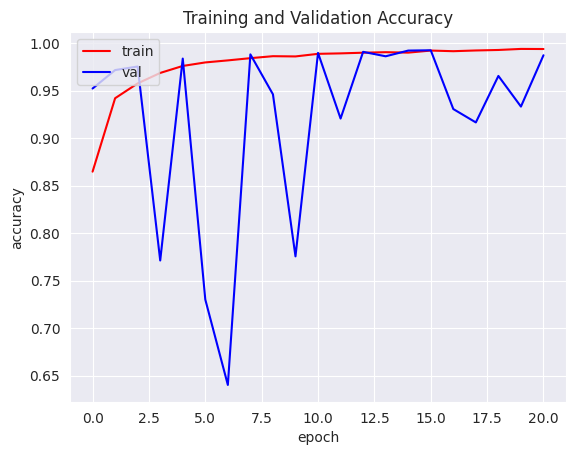

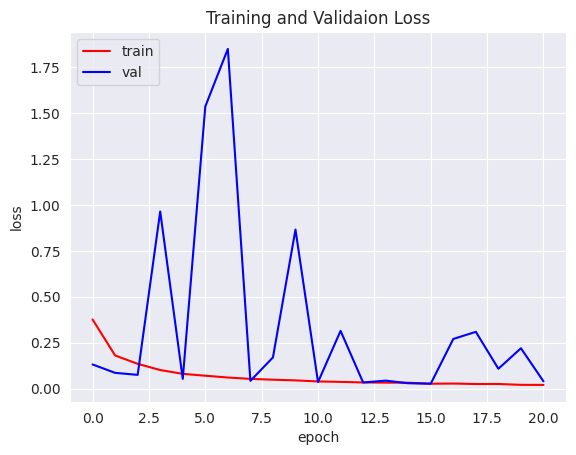

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## Konversi Model

In [22]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [5]:
!pip install tensorflowjs

  Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached ml_dtypes-0.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (615.3 MB)
Using cached keras-3.7.0-py3-none-any.whl (1.2 MB)
Using cached ml_dtypes-0.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
Using cached tensorboard-2.18.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Atte

In [1]:
!tensorflowjs_converter \
    --input_format tf_saved_model \
    /content/saved_model/ \
    /content/tfjs_model

2024-12-17 18:33:24.212291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734460404.233509   13022 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734460404.240001   13022 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 18:33:24.263210: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training

In [2]:
converter = tf.lite.TFLiteConverter.from_saved_model("/content/saved_model/")
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

## Inference (Optional)

Saving Basmati (1).jpg to Basmati (1) (4).jpg


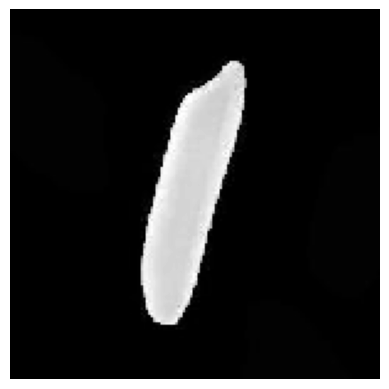

Predicted class: [1]


In [8]:
import tensorflow as tf
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# Load the SavedModel
model = tf.saved_model.load('/content/saved_model')

# Function to upload and preprocess the image
def upload_and_preprocess_image():
    uploaded = files.upload()
    for fn in uploaded.keys():
        # Load and preprocess the image
        img_path = fn
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150), color_mode='grayscale')
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize the image

        # Display the uploaded image
        plt.imshow(img_array[0].squeeze(), cmap='gray')  # Display the image array in grayscale
        plt.axis('off')
        plt.show()

        return img_array

# Upload and preprocess the image
img_array = upload_and_preprocess_image()

# Run inference using the loaded SavedModel
infer = model.signatures['serving_default']
predictions = infer(input_1=tf.constant(img_array))['dense_2']

# Process the output
predicted_class = np.argmax(predictions.numpy(), axis=1)
print(f"Predicted class: {predicted_class}")